In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

2024-09-12 12:10:43.522242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 12:10:43.523510: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 12:10:43.528526: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 12:10:43.542618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 12:10:43.562626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
df = pd.read_csv("data/dataset_final.csv")
df.head()

,Time,Temperature,Humidity,Air Quality,Light,Loudness
0,1623781306,37.94,28.94,75,644,106
1,1623781316,37.94,29.00,75,645,145
2,1623781326,37.88,28.88,75,644,146
3,1623781336,37.72,28.94,75,646,139
4,1623781346,37.69,29.19,75,644,155


# preprocessing 

In [3]:
df.dtypes

Time             int64
Temperature    float64
Humidity       float64
Air Quality      int64
Light            int64
Loudness         int64
dtype: object

In [4]:
df.columns

Index(['Time', 'Temperature', 'Humidity', 'Air Quality', 'Light', 'Loudness'], dtype='object')

In [5]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Set 'Time' column as index
df.set_index('Time', inplace=True)

# Display basic statistics of the dataset
df.head()

,Temperature,Humidity,Air Quality,Light,Loudness
Time,,,,,
2021-06-15 18:21:46,37.94,28.94,75,644,106
2021-06-15 18:21:56,37.94,29.00,75,645,145
2021-06-15 18:22:06,37.88,28.88,75,644,146
2021-06-15 18:22:16,37.72,28.94,75,646,139
2021-06-15 18:22:26,37.69,29.19,75,644,155


In [6]:
df.shape

(6558, 5)

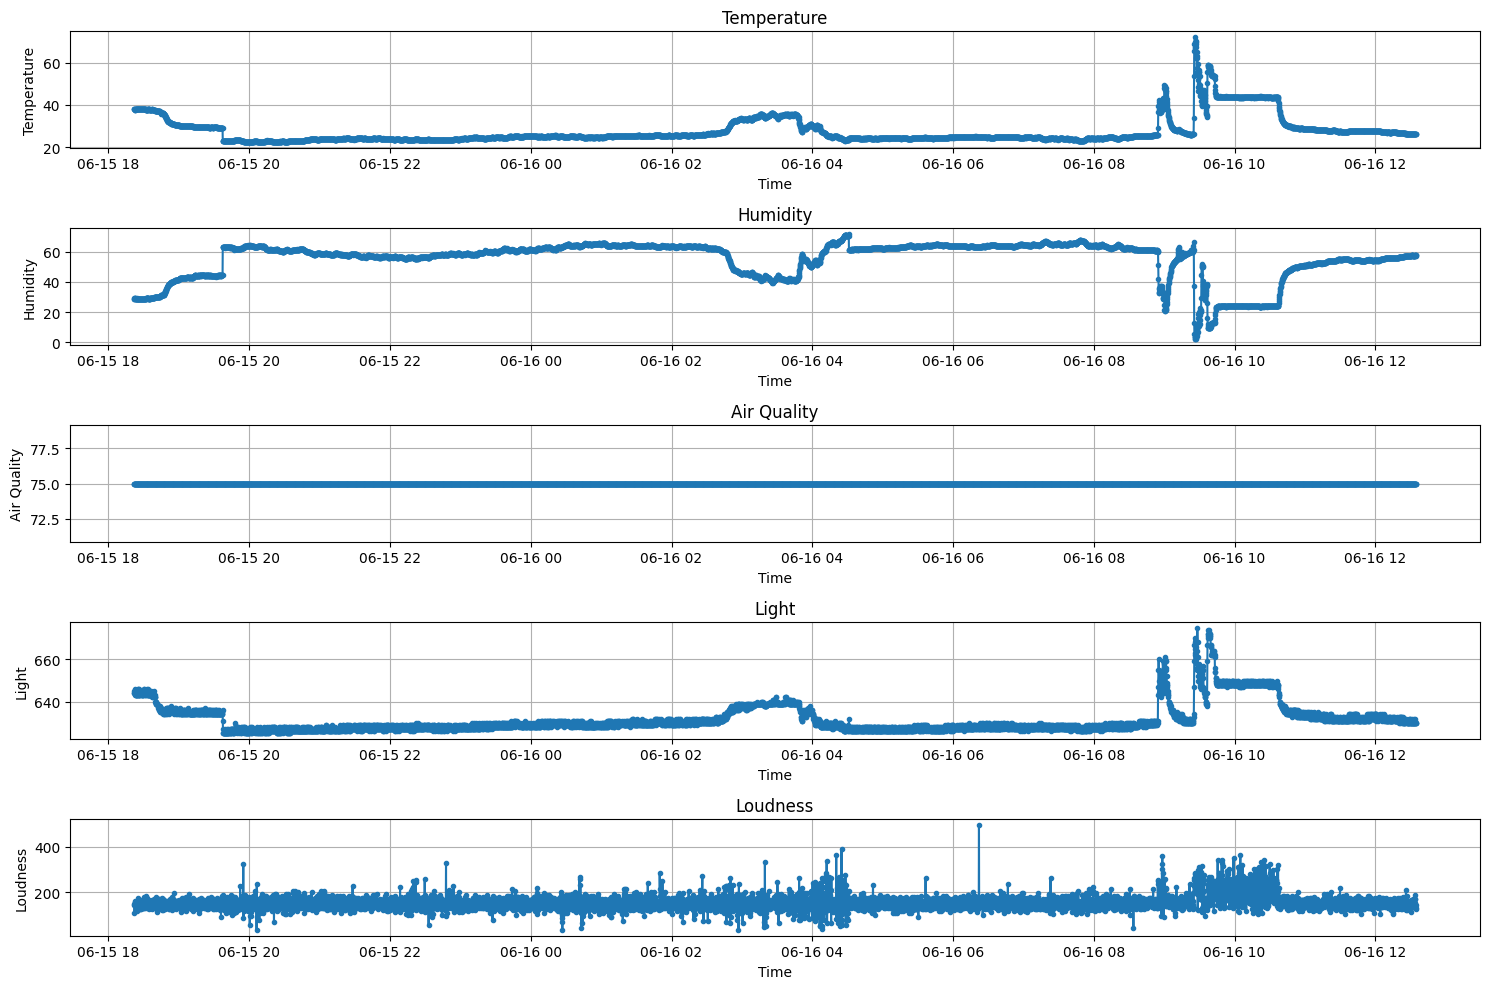

In [7]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i + 1)
    plt.plot(df.index, df[col], marker='.', linestyle='-')
    plt.title(col)
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(True)
plt.tight_layout()
plt.show()

### Correlated Events:
The fluctuations in **temperature**, **humidity**, **light**, and **loudness** around **06-16 02 to 06-16 04** suggest some external activity in the room or environment. This could be an event like people entering the room, turning on/off equipment, or significant movement.

### Environmental Control:
The fact that **air quality** remains constant throughout suggests either excellent environmental control or a lack of sufficient variation in air quality during the monitored period.

### Anomalies:
The spikes in **temperature**, **humidity**, and **loudness** could be potential anomalies depending on the typical behavior expected in this environment. These could be worth investigating further using **anomaly detection techniques**.


# data normalization

In [24]:
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df.values)

# create sequences

In [9]:
# Define sequence length
sequence_length = 10

# Create sequences of data
def create_sequences(data, sequence_length):
    X = []
    for i in range(len(data) - sequence_length + 1):
        X.append(data[i:i+sequence_length])
    return np.array(X)

# Create sequences for training
X_train = create_sequences(df_normalized, sequence_length)

In [10]:
# Split the normalized sequences into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.2, shuffle=True, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (5239, 10, 5)
Shape of X_val: (1310, 10, 5)


In [11]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),  # Output only the last time step
    RepeatVector(X_train.shape[1]),  # Repeat the output across all time steps
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(X_train.shape[2])  # Output layer with the same number of features as input
])

# Compile the model
model.compile(loss='mse', optimizer='adam')  # Mean Squared Error loss

2024-09-12 12:10:50.576910: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/vidushee/downloads/IoT-sensor-data-anomaly-detection/iot_anomaly/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/50


2024-09-10 16:00:31.722385: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0322 - val_loss: 0.0017
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 9.8623e-04 - val_loss: 0.0011
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 9.2977e-04 - val_loss: 0.0011
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 9.4676e-04 - val_loss: 0.0012
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 9.6921e-04 - val_loss: 0.0011
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0010 - val_loss: 9.4708e-04
Epoch 12/50
164/164 ━━━━━━━━━━━

In [13]:
# Path to the directory and file
directory = '../artifacts'
filename = os.path.join(directory, 'model.pkl')

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [14]:
# Generate predictions for training and validation sets
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [16]:
# Calculate reconstruction error for training and validation sets
train_reconstruction_error = np.mean(np.square(X_train - train_predictions), axis=(1, 2))
val_reconstruction_error = np.mean(np.square(X_val - val_predictions), axis=(1, 2))

In [33]:
def visualize_anomalies(sensor_data, anomalies, sensor_name):
    plt.figure(figsize=(15, 6))
    plt.plot(sensor_data, label='Sensor Data', color='blue')
    anomalies_reshaped = np.tile(train_anomalies, (X_train.shape[0] // train_anomalies.shape[0], 1))
    print(anomalies.shape)
    print(sensor_data.shape)
    # Highlight anomalies with a different color or marker
    anomaly_indices = np.where(anomalies)[0]
    anomaly_indices_repeated = np.repeat(anomaly_indices, sensor_data.shape[1])
    print(anomaly_indices)
    plt.scatter(anomaly_indices_repeated, sensor_data[anomalies], label='Anomalies', color='red', marker='o')
    
    plt.title(f'Sensor Data with Anomalies ({sensor_name})')
    plt.xlabel('Time')
    plt.ylabel('Sensor Reading')
    #plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(sensor_name+'.png')

{False, True}
(5239,)
(5239, 10)
[  18   58  216  273  388  394  404  675  709  804 1247 1275 1283 1357
 1399 1486 1585 1730 1778 1870 1877 2486 2536 2573 2643 2764 2856 2867
 2905 2906 2937 2947 3078 3128 3158 3350 3399 3400 3509 3532 3661 3702
 3857 4085 4295 4493 4572 4596 4896 4945 5047 5048 5058]


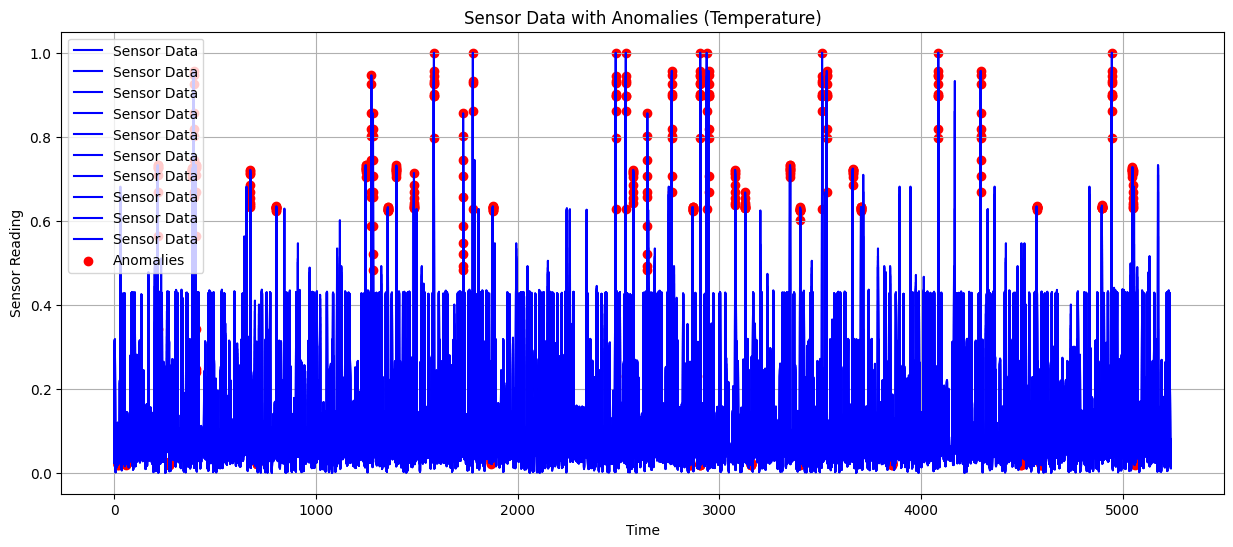

{False, True}
(5239,)
(5239, 10)
[  18   58  216  273  388  394  404  675  709  804 1247 1275 1283 1357
 1399 1486 1585 1730 1778 1870 1877 2486 2536 2573 2643 2764 2856 2867
 2905 2906 2937 2947 3078 3128 3158 3350 3399 3400 3509 3532 3661 3702
 3857 4085 4295 4493 4572 4596 4896 4945 5047 5048 5058]


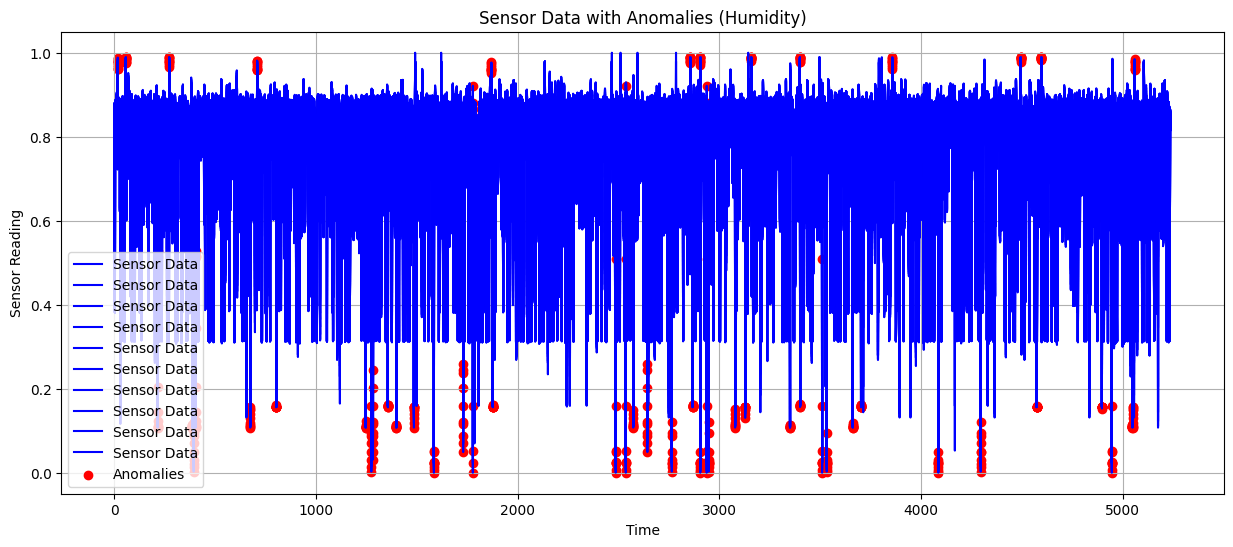

{False, True}
(5239,)
(5239, 10)
[  18   58  216  273  388  394  404  675  709  804 1247 1275 1283 1357
 1399 1486 1585 1730 1778 1870 1877 2486 2536 2573 2643 2764 2856 2867
 2905 2906 2937 2947 3078 3128 3158 3350 3399 3400 3509 3532 3661 3702
 3857 4085 4295 4493 4572 4596 4896 4945 5047 5048 5058]


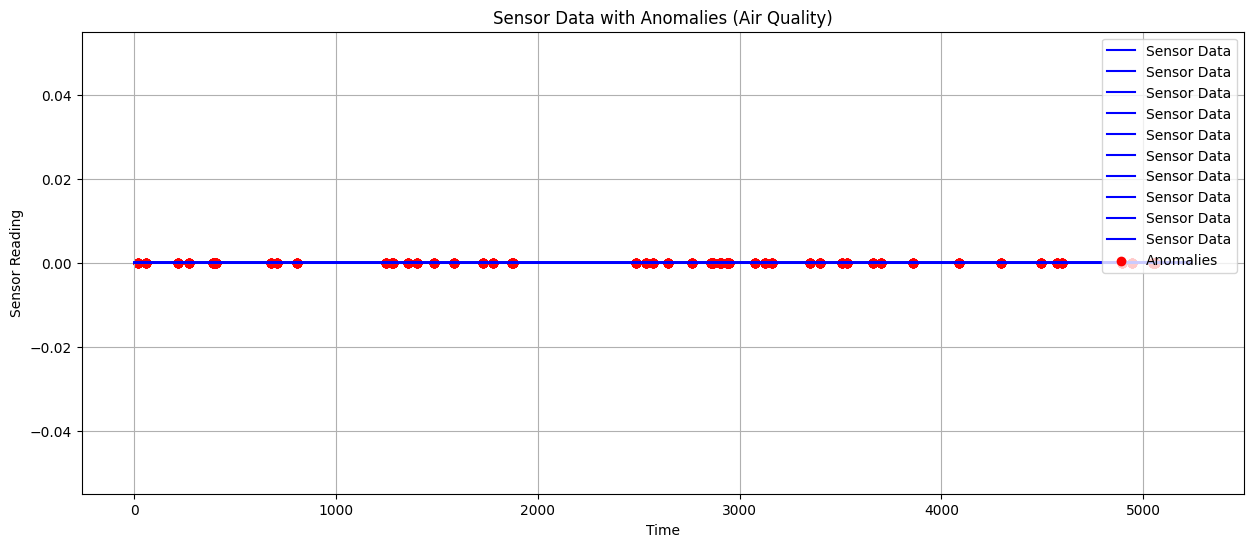

{False, True}
(5239,)
(5239, 10)
[  18   58  216  273  388  394  404  675  709  804 1247 1275 1283 1357
 1399 1486 1585 1730 1778 1870 1877 2486 2536 2573 2643 2764 2856 2867
 2905 2906 2937 2947 3078 3128 3158 3350 3399 3400 3509 3532 3661 3702
 3857 4085 4295 4493 4572 4596 4896 4945 5047 5048 5058]


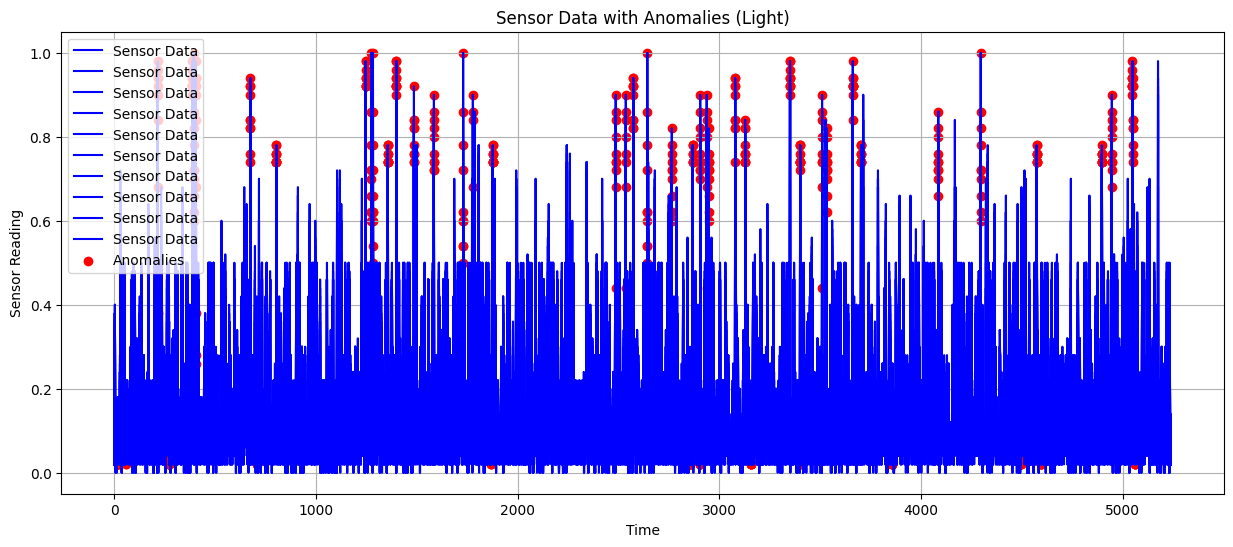

{False, True}
(5239,)
(5239, 10)
[  18   58  216  273  388  394  404  675  709  804 1247 1275 1283 1357
 1399 1486 1585 1730 1778 1870 1877 2486 2536 2573 2643 2764 2856 2867
 2905 2906 2937 2947 3078 3128 3158 3350 3399 3400 3509 3532 3661 3702
 3857 4085 4295 4493 4572 4596 4896 4945 5047 5048 5058]


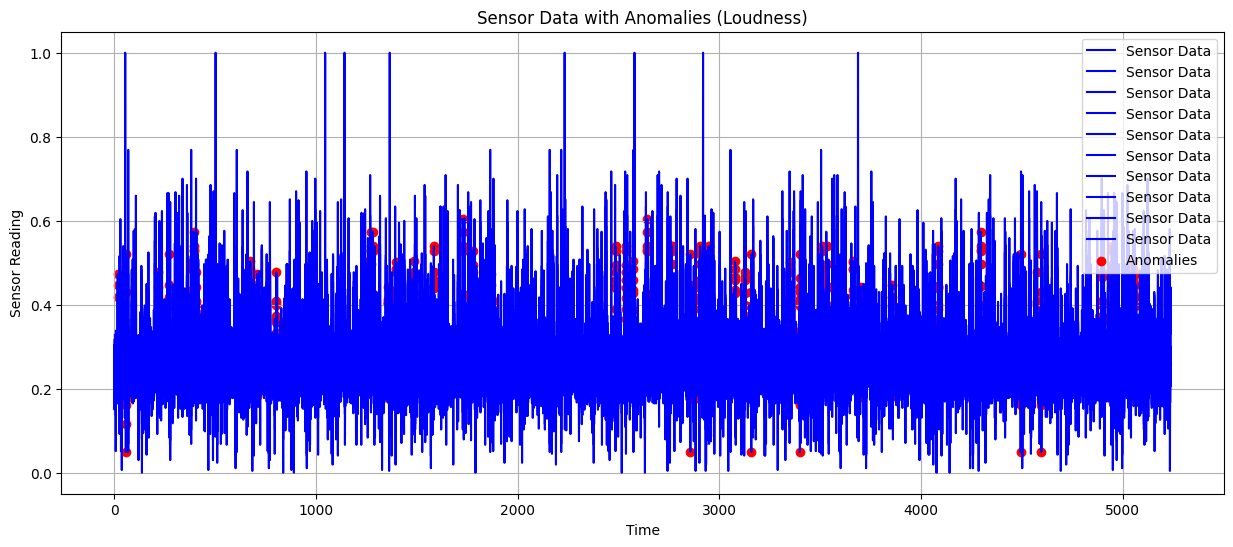

In [34]:
sensor_names = ['Temperature', 'Humidity', 'Air Quality', 'Light', 'Loudness']

for i, sensor_name in enumerate(sensor_names):
    # Calculate reconstruction error for training and validation sets
    train_reconstruction_error = np.mean(np.square(X_train - train_predictions), axis=(1, 2))
    val_reconstruction_error = np.mean(np.square(X_val - val_predictions), axis=(1, 2))
    
    # Calculate mean and standard deviation of reconstruction error for training set
    mean_reconstruction_error = np.mean(train_reconstruction_error)
    std_reconstruction_error = np.std(train_reconstruction_error)

    # Set threshold as mean + 3 * standard deviation
    threshold = np.percentile(train_reconstruction_error, 99)
    
    # Detect anomalies in training set for current sensor
    train_anomalies = train_reconstruction_error > threshold

    # Detect anomalies in validation set for current sensor
    val_anomalies = val_reconstruction_error > threshold
    print(set(train_anomalies))
    visualize_anomalies(X_train[:, :, i], train_anomalies,sensor_name)
    # You can plot the original sensor data and highlight the anomalies using a different color or marker

In [21]:
from sklearn.metrics import mean_squared_error

# Calculate reconstruction error for training and validation sets
train_reconstruction_error = np.mean(np.square(X_train - train_predictions), axis=(1, 2))
val_reconstruction_error = np.mean(np.square(X_val - val_predictions), axis=(1, 2))

# Calculate MSE for normal and anomalous samples separately
normal_train_mse = train_reconstruction_error[~train_anomalies]
anomalous_train_mse = train_reconstruction_error[train_anomalies]

normal_val_mse = val_reconstruction_error[~val_anomalies]
anomalous_val_mse = val_reconstruction_error[val_anomalies]

# Print mean MSE for normal and anomalous samples
print("Mean MSE for Normal Training Samples:", np.mean(normal_train_mse))
print("Mean MSE for Anomalous Training Samples:", np.mean(anomalous_train_mse))

print("Mean MSE for Normal Validation Samples:", np.mean(normal_val_mse))
print("Mean MSE for Anomalous Validation Samples:", np.mean(anomalous_val_mse))

Mean MSE for Normal Training Samples: 0.15459230884909073
Mean MSE for Anomalous Training Samples: 0.2628870733635758
Mean MSE for Normal Validation Samples: 0.1538667791452027
Mean MSE for Anomalous Validation Samples: 0.26309332386488654


In [25]:
import numpy as np

# Example new data point with features: Temperature, Humidity, Air Quality, Light, Loudness
new_data_point = np.array([[37.5, 28.8, 75, 645, 120]])

# Repeat the data point to match the sequence length (e.g., 10 time steps)
sequence_length = 10
new_sequence = np.repeat(new_data_point, sequence_length, axis=0)

# Reshape the sequence to match the model's input shape (1 sequence, 10 time steps, 5 features)
new_sequence = new_sequence.reshape((1, sequence_length, new_data_point.shape[1]))

# Predict using the trained model
new_prediction = model.predict(new_sequence)

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(new_sequence - new_prediction), axis=(1, 2))

# Set a threshold based on training data error
threshold = 0.02  # Adjust based on your training/validation data

# Check if it's an anomaly
if reconstruction_error > threshold:
    print("Anomaly detected!")
else:
    print("Normal data point.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Anomaly detected!
